_(Note: this is not a 343 minute read.)_

Just like every other scientist, engineer, or [Matt](https://www.mcsweeneys.net/articles/men-in-tech-to-work-with-and-or-go-on-tinder-dates-with-before-you-a-woman-in-tech-get-fed-up-with-this-industry-and-leave-san-francisco-forever), I'm pretty into rock climbing. Being carless in NYC, I primarily climb indoors. One of the first things that you learn when going to a climbing gym is that you don't get to grab on to every "hold" (the bright plastic things on the wall). Different colored holds correspond to different "routes", and you challenge yourself by only using the holds for a particular route.

{{< figure src="/images/bayesian-rock-climbing/the_wall.jpg" caption="Embarrassingly, the only picture I have of myself climbing is on autobelay." >}}


How much do you challenge yourself? Well, that depends on the route. Each route has a "grade" or "rating" which describes the route's difficulty. In the US, routes that require a safety rope use the Yosemite Decimal System ([Source](https://www.sportrock.com/post/understanding-climbing-grades)).

{{< figure src="/images/bayesian-rock-climbing/yds.png" >}}

For bouldering problems (routes that are short and quick and don't require a rope), there's a separate, "V-scale" US rating system.

{{< figure src="/images/bayesian-rock-climbing/vscale.png" >}}

In summary, for both climbing routes and bouldering problems, there are rating systems where the increase in the numerical rating corresponds to an increase in difficulty. How are these ratings decided?

They're just made up.

This kind of blew me away when I first started climbing. I assumed that you would be required to do certain types of moves for certain ratings. In practice, route setters place the holds for a new route, they have a general idea of how hard they think the route is, and then they have a couple other people climb it and give their opinion.

Naturally, this got me thinking:

_If I had a dataset of which routes people were and were not able to climb, could I model a more objective ratings system?_

Probably? 

Unfortunately, I do not have that dataset. 

I did find something close, though, and I was then able to build _some_ sort of model. In the [spirit](https://en.wikipedia.org/wiki/All_models_are_wrong) of George Box, I built a model that is most definitely wrong, but it may be useful. If nothing else, I'm hoping this model will serve as  light introduction to Bayesian modeling in Stan.

## When People Tell You What They've Done, Believe Them

In searching for a dataset of attempted climbs, I stumbled upon [this](https://www.kaggle.com/dcohen21/8anu-climbing-logbook) Kaggle dataset. The user who uploaded the dataset had scraped the website [www.8a.nu](https://www.8a.nu) which is a website where users can log outdoor climbing routes that they have successfully climbed. This is the first issue with the data: it only contains successful routes that users have climbed. As a meaningful consolation, the users do log whether or not they climbed the route on their first try (aka they "flashed" the route in climber parlance). This piece of information gives me the outcome variable I need to build a model!

The dataset consists of a SQLite database with 4 tables containing all sorts of information about the routes and the users who attempted them. All told, there are almost 5 million logged climbs from almost 67K users.

Let's go ahead and load the data into a Pandas DataFrame. To keep things manageable, we'll limit to climbs in the USA.

In [1]:
%config InlineBackend.figure_format = 'retina'
import datetime as dt
import pickle
import sqlite3

import altair as alt
import arviz as az
import cycler
import matplotlib.pyplot as plt
import nest_asyncio
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

In [2]:
# Required before importing stan in a jupyter notebook.
nest_asyncio.apply()

In [3]:
import stan

/home/er/.pyenv/versions/route-response/lib/python3.9/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [4]:
pd.set_option("display.max_columns", None)

In [5]:
# Whether or not to use the model that's already been fitted.
USE_CACHE = True

In [6]:
conn = sqlite3.connect("database.sqlite")
query = """
SELECT
  ascent.user_id
  , ascent.crag
  , ascent.climb_type
  , ascent.name AS route_name
  , ascent.date AS ascent_date
  , REPLACE(ascent.crag, ' ', '_')
      || '__' || REPLACE(ascent.name, ' ', '_')
      || '__' || CASE WHEN ascent.climb_type = 1 THEN 'boulder' ELSE 'rope' END
      AS route_id
  , grade.usa_routes
  , grade.usa_boulders
  , method.name AS method_name
FROM ascent
JOIN grade ON grade.id = ascent.grade_id
JOIN method ON method.id = ascent.method_id
WHERE
  ascent.country = 'USA'
"""
df = pd.read_sql_query(query, conn)

In [7]:
df.head()

,user_id,crag,climb_type,route_name,ascent_date,route_id,usa_routes,usa_boulders,method_name
0,25,Hueco Tanks,1,Frogger,917823600,Hueco_Tanks__Frogger__boulder,5.12d,V9,Redpoint
1,25,Hueco Tanks,1,Sex After Death,917823600,Hueco_Tanks__Sex_After_Death__boulder,5.12d,V9,Redpoint
2,25,Hueco Tanks,1,Red,915145200,Hueco_Tanks__Red__boulder,5.12d,V9,Redpoint
3,25,Hueco Tanks,1,Better Eat Your Wheaties,949359600,Hueco_Tanks__Better_Eat_Your_Wheaties__boulder,5.12c,V8/9,Redpoint
4,25,Horse Flats,1,Blank Generation,957132000,Horse_Flats__Blank_Generation__boulder,5.12d,V9,Redpoint


Each row in the above table corresponds to an ascent by a user. The `crag` refers to the area where the route is located. The `climb_type` is `1` if it's a bouldering route, and `0` if it's a rope route. The `ascent_date` is in [Unix time](https://en.wikipedia.org/wiki/Unix_time). `usa_routes` and `usa_boulders` refer to the user's rating of the route. For some reason, many routes have both a rope and bouldering rating. Lastly, `method_name` corresponds to "how" the user climbed the route. Options include:

- `Onsight`: The user climbed the route on their first try without knowing anything about the route.
- `Flash`: The user climbed the route on their first try, but they had studied the route ahead of time.
- `Redpoint`: The user successfully climbed the route after multiple attempts.
- `Toprope`: The user climbed the route top rope rather than lead style (top roping is easier).

Lastly, I've created a unique `route_id` for each route which is a combination of the `crag`, the `route_name`, and `climb_type`.

Let's go ahead and create some derived columns from the data. To start, we'd like to assign a single `route_rating` and `bouldering_grade` to each route, rather than each user specifying their own rating. We'll pick the single ratings by assigning the most popular user rating.

In [8]:
# Fix dtypes
def cast_columns(
    df: pd.DataFrame,
    route_ratings: pd.CategoricalDtype,
    bouldering_grades: pd.CategoricalDtype,
) -> pd.DataFrame:
    # Fix dtypes
    df["ascent_date"] = pd.to_datetime(df["ascent_date"], unit="s")
    df["usa_boulders"] = df["usa_boulders"].astype(bouldering_grades)
    df["usa_routes"] = df["usa_routes"].astype(route_ratings)
    return df

In [9]:
route_ratings = pd.CategoricalDtype(
    categories=[
        "5.1",
        "5.2",
        "5.3",
        "5.4",
        "5.5",
        "5.6",
        "5.7",
        "5.8",
        "5.9",
        "5.10a",
        "5.10b",
        "5.10c",
        "5.10d",
        "5.11a",
        "5.11b",
        "5.11c",
        "5.11d",
        "5.12a",
        "5.12b",
        "5.12c",
        "5.12d",
        "5.13a",
        "5.13b",
        "5.13c",
        "5.13d",
        "5.14a",
        "5.14b",
        "5.14c",
        "5.14d",
        "5.15a",
        "5.15b",
        "5.15c",
    ],
    ordered=True,
)
bouldering_grades = pd.CategoricalDtype(
    [
        "V0",
        "V1",
        "V2",
        "V3",
        "V4",
        "V5",
        "V6",
        "V7",
        "V8",
        "V9",
        "V10",
        "V11",
        "V12",
        "V13",
        "V14",
        "V15",
        "V16",
        "V17",
        "V18",
        "V19",
        "V20",
    ],
    ordered=True,
)
df = cast_columns(df, route_ratings, bouldering_grades)

In [10]:
# Routes can be graded differently by different people.
# Here, we pick the most popular grade and assign it.
route_modes = (
    df.groupby("route_id")["usa_routes"]
    .agg(lambda x: pd.Series.mode(x).get(0))
    .to_frame()
    .rename(columns={"usa_routes": "route_rating"})
    .astype(route_ratings)
)
bouldering_modes = (
    df.groupby("route_id")["usa_boulders"]
    .agg(lambda x: pd.Series.mode(x).get(0))
    .to_frame()
    .rename(columns={"usa_boulders": "bouldering_grade"})
    .astype(bouldering_grades)
)
# The new column will be `route_rating`
df = pd.merge(
    df,
    route_modes,
    how="left",
    left_on="route_id",
    right_index=True,
)
# The new column will be `bouldering_grade`
df = pd.merge(
    df,
    bouldering_modes,
    how="left",
    left_on="route_id",
    right_index=True,
)

Next, we assign a `label` which will indicate whether or not the user climbed the route on their first try. It looks like 33% of ascents were climbed on their first try.

In [11]:
df["label"] = df["method_name"].isin(["Onsight", "Flash"])

In [12]:
df["label"].mean()

0.3353379213201745

## Subset the data

Next, let's cut out some data in order to aid our downstream modeling. Some users have logged multiple ascents for the same route. We'll only keep the first ascent.

In [13]:
# Let's just keep the first ascent
first_ascents = df.groupby(["user_id", "route_id"])["ascent_date"].min().to_frame()
print(f"Total USA ascents: {len(df):,}")
df = pd.merge(df, first_ascents, on=["user_id", "route_id", "ascent_date"])
# This is a bit lazy -- "first" is a bit ill-defined in this context.
df = df.drop_duplicates(subset=["user_id", "route_id"], keep="first")
print(f"First USA ascents: {len(df):,}")

Total USA ascents: 658,822
First USA ascents: 638,305


There are many users who have only logged a couple ascents. Likewise, there are many routes that have only be climbed by a couple users. The lack of data for these "rare" users and routes can make modeling difficult. So, we will limit our dataset to only include users who have climbed at least 20 routes and routes that have been climbed by at least 20 people. The code to do this ends up being this odd iterative process since every time we remove users, some routes may no longer have been climbed by enough users, and vice versa. On the odd chance that there's a weirdly astute reader of my blog, they will notice that the below function is very similar to the one that I [used]({{< ref "/blog/implicit-mf-part-1" >}}) for limiting the interactions matrix for a recommender system.

In [14]:
def threshold_ascents(df: pd.DataFrame, limit: int = 5) -> pd.DataFrame:
    """
    Limit all ascents to only users who have logged >= `limit` ascents
    and only routes that have >= `limit` ascents.

    This is an iterative process because limiting the users can then
    change which routes have >= `limit` ascents. So, this function
    alternates back and forth, limiting users and then limiting routes,
    until both stabilize.
    """
    done = False
    df_lim = df.copy()
    print(f"Start number of ascents: {len(df_lim):,}.")
    while not done:
        start_shape = df_lim.shape

        user_mask = df_lim["user_id"].value_counts() >= limit
        users_to_keep = user_mask[user_mask].index
        df_lim = df_lim[df_lim["user_id"].isin(users_to_keep)]

        route_mask = df_lim["route_id"].value_counts() >= limit
        routes_to_keep = route_mask[route_mask].index
        df_lim = df_lim[df_lim["route_id"].isin(routes_to_keep)]

        end_shape = df_lim.shape
        if start_shape == end_shape:
            done = True
    print(f"End number of ascents: {len(df_lim):,}.")
    return df_lim

In [15]:
df = threshold_ascents(df, limit=20)

Start number of ascents: 638,305.
End number of ascents: 232,887.


## Route Response Theory

Finally, we can build our model. Prior to doing this, though, and in keeping with the aforementioned similarity to recommendation systems, we must first build mappers between the `ids` in our data and _indices_ in an array. Specifically, we map the `route_id` to a `route_idx` (sorry for the poor variable naming) and the `user_id` to a `user_idx`. After building the mappers, we use them to create new columns in the dataset.

In [16]:
# Create mappers between IDs and matrix indices.
# Also, sort the IDs so that this operation is reproducible.
route_idx_to_id = dict(enumerate(sorted(df["route_id"].unique())))
route_id_to_idx = {v: k for k, v in route_idx_to_id.items()}

user_idx_to_id = dict(enumerate(sorted(df["user_id"].unique())))
user_id_to_idx = {v: k for k, v in user_idx_to_id.items()}

df["route_idx"] = df["route_id"].map(route_id_to_idx)
df["user_idx"] = df["user_id"].map(user_id_to_idx)

Ok _now_ we can do some modeling. To model our users, routes, and ascents, we will turn to Item Response Theory (IRT). For funsies, we'll call our situation Route Response Theory (RRT). I first learned about IRT a couple years ago when reading [this](https://multithreaded.stitchfix.com/blog/2017/12/13/latentsize/) Stitch Fix blog post. If you read the post, you will learn that IRT was originally created by the Educational Testing Service (ETS) as a way to compare students who had seen different problems on the SATs. In classical IRT, you have students, questions, and they can get questions right or wrong. In RRT, we have climbers, routes, and the climbers can climb the route on their first try or on more tries. This means that we can directly map the IRT model onto our climbing situation.

So what's the Route Response Theory model? Thankfully, it's relatively simple. We assume that each climber $c$ has some ability $a_{c}$, and each route $r$ has some difficulty $d_{r}$. If we then view our task from the machine learning or "prediction" side of things, we want to predict whether or not the climber climbed the route on the first try, and so we build a logistic regression. You can think of our feature vector as consisting of one-hot-encoded climbers and routes, and the feature values are 1 for climbers and -1 for routes (and we also have a bias term). This would end up looking something like:

$$\hat{y}(c, r) = logistic(a_{c} - d_{r} + \mu)$$

where $\mu$ is the bias term. 

We're not doing machine learning, though. We want to do statistical inference, so let's reorient ourselves as a Bayesian. The scariest part about trying to do Bayesian modeling is that the moment you show your model to any proper statistician, they will point out all sorts of nuances about why what you've done is wrong and why your priors are illegitimate. Even worse, if you try to explain what's going on with your model or god-forbid write a blog post about it, you will get an earful about why everything you've said is technically incorrect. The best thing you can do is to try to keep your model simple so that there is less ammunition for unwanted feedback. It turns out this is also how you should approach Bayesian modeling; build a simple model, make sure it's correct, and then add complexity. 

Nevertheless, we must power through the scariness of making our statistics public. 

If we reorient our model towards a Bayesian standpoint, we want to maximize some likelihood that looks like:

$$P(y_{c, r} = 1 | a_{c},d_{r}) =  \frac{1}{1 + e^{a_{c} - d_{r} + \mu}}$$

where

$$a_{c} \sim Normal(0, \sigma_{c})$$
$$r_{d} \sim Normal(0, \sigma_{d})$$

If you're confused about why the above normals have zero mean but some parametrized variance, it has something to do with the fact that we're actually building a random effects model.

_Note: the author still does not understand random effects models and so they will not be able to explain this any further._

The goal of Bayesian inference in this case is to infer the parameters $a_{c}$ (the climber abilities) and $r_{d}$ (the route difficulties). For this blog post, we'll use the probabilistic programming language [Stan](https://mc-stan.org/) to perform this inference. I've used both Stan and PyMC3 in the past and generally preferred Stan solely due to it having better error messages that allowed me to debug quicker. With that said, Stan's Python support is pretty poor (and I think it got worse between versions of PyStan?). R's a better language for Stan, but I don't know R, so here we are (har har).

The oddest part about Stan is that it really is its own language. For using Stan in Python, this means that you have to write out your model in Stan code in a Python string. On the plus side for me, Stan code is kind of MATLAB-y, so I regrettably feel pretty comfortable with it. The model's below. I will pass 3 arrays in as `data`: `routes`, `users`, and `labels`. `routes` and `users` are arrays with lengths equal to the number of ascents in the dataset, and their elements correspond to the `route_idx` and `user_idx` for a particular ascent. `label` is then a 1 or a 0 based on whether or not the user climbed the route on the first try. 

The model parameters that I want to learn will be packaged up into Stan vectors. I'll have a vector of the user abilities and the route difficulties. I'll also have a mean ability / bias parameter. Finally, the model itself consists of the aforementioned Route Response Theory model. Stan has support for vectorized operations, which I've employed below. I did leave the non-vectorized version of the model commented out for pedogical posterity.

In [17]:
stan_code = """
data {
    int<lower=1> num_ascents;
    int<lower=1> num_users;
    int<lower=1> num_routes;
    int<lower=1, upper=num_routes> routes[num_ascents];
    int<lower=1, upper=num_users> users[num_ascents];
    int<lower=0, upper=1> labels[num_ascents];    
}
parameters {
    real mean_ability; 
    vector[num_users] user_ability; // user_ability - mean_ability
    vector[num_routes] route_difficulty;
}
model {
    user_ability ~ std_normal();
    route_difficulty ~ std_normal();
    mean_ability ~ std_normal();
    
    // Non-vectorized version
    //
    // for (a in 1:num_ascents)
    //     labels[a] ~ bernoulli_logit(
    //         user_ability[users[a]] - route_difficulty[routes[a]] + mean_ability
    //     );
    
    // Vectorized model
    labels ~ bernoulli_logit(user_ability[users] - route_difficulty[routes] + mean_ability);
    

}
"""

After defining the stan code, we'll need to package up all of the `data` that the `data` block of the code expects into a dictionary. Stan is 1-indexed, so we'll offset the `route_idx` and `user_idx` by 1.

In [18]:
stan_data = {
    "num_ascents": len(df),
    "num_users": df["user_id"].nunique(),
    "num_routes": df["route_id"].nunique(),
    # Add 1 to these so that they are 1-indexed for STAN.
    "routes": (df["route_idx"].values + 1).astype(int),
    "users": (df["user_idx"].values + 1).astype(int),
    "labels": df["label"].values.astype(int),
}

In [19]:
print(f"Num Users: {stan_data['num_users']:,}")
print(f"Num Routes: {stan_data['num_routes']:,}")

Num Users: 2,977
Num Routes: 4,288


Next, we compile the Stan code.

In [ ]:
posterior = stan.build(stan_code, data=stan_data, random_seed=666)

And finally, we fit the model. As I recall, this took a couple hours (probabilistic programming can be pretty slow!). To simplify running the Jupyter notebook that this blog post was written in, I cached the fitted model to disk after fitting. I also generate and cache some other information about the fitted model using [ArviZ](https://arviz-devs.github.io/arviz/), a library that helps with analyzing and plotting Bayesian modeling results.

In [21]:
if USE_CACHE:
    df = pd.read_pickle("df.pkl")
    fit_df = pd.read_pickle("fit_df.pkl")
    idata = az.from_netcdf("inference_data.nc")
    model_summary = az.summary(idata, fmt="xarray")
else:
    # Do the modeling
    fit = posterior.sample(num_chains=4, num_samples=1000)

    # Write the data
    df.to_pickle("df.pkl")

    fit_df = fit.to_frame()
    fit_df.to_pickle("fit_df.pkl")

    idata = az.convert_to_inference_data(fit)
    idata.to_netcdf("inference_data.nc")
    model_summary = az.summary(idata, fmt="xarray")

## Model Quality

We start analyzing our modeling results by plotting the MCMC traces. We'll plot the `mean_ability` and 20 `user_ability` and `route_difficulty` parameters. The trace plots are on the right, and the density plots (which are like a smoth histogram) are on the left. For the trace plots, [academic papers](https://arxiv.org/abs/1909.11827) tell you to look for, and I quote, "hairy caterpillars". Our traces look reasonably hairy and caterpillar-y. For the denisty plots, we can see that our various parameters look fairly Gaussian and not too crazy. Seems like things are looking OK!

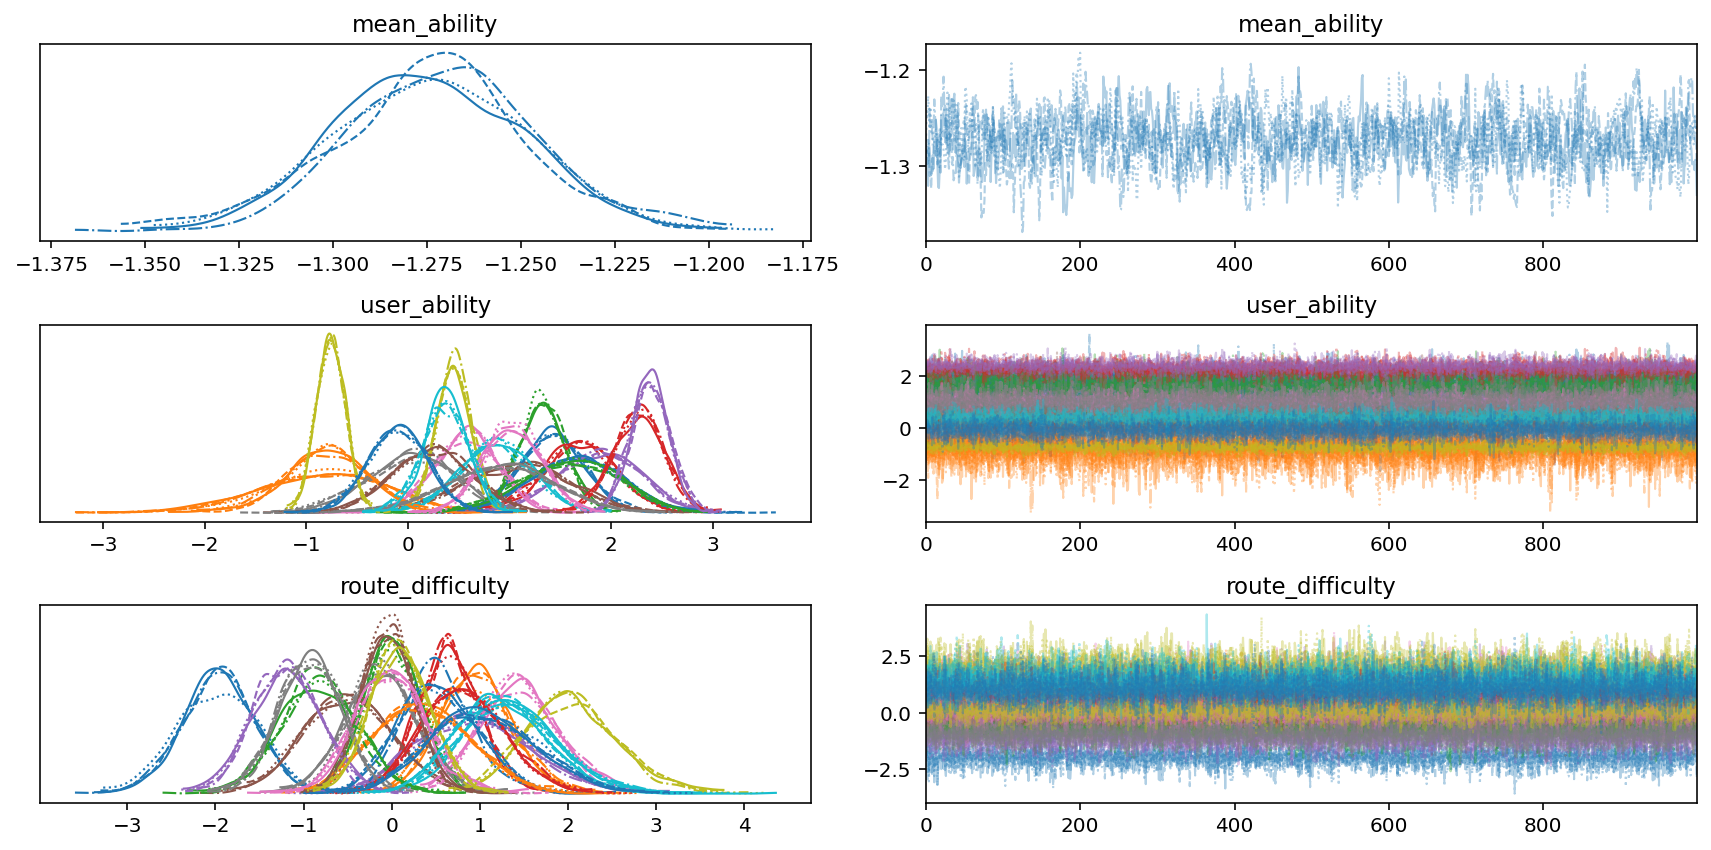

In [22]:
axs = az.plot_trace(
    idata,
    var_names=["mean_ability", "user_ability", "route_difficulty"],
    coords={"user_ability_dim_0": slice(0, 20), "route_difficulty_dim_0": slice(0, 20)},
)


plt.tight_layout()
None

Next, we can investigate the infamous $\hat{R}$, which is a "convergence diagnostic" for each parameter of the fitted model. The latest [research](https://arxiv.org/abs/1903.08008) says that you want it to be less than 1.01. Looking at the histograms below of $\hat{R}$ values for `user_ability` and `route_difficulty`, it seems like they all lie below 1.01.

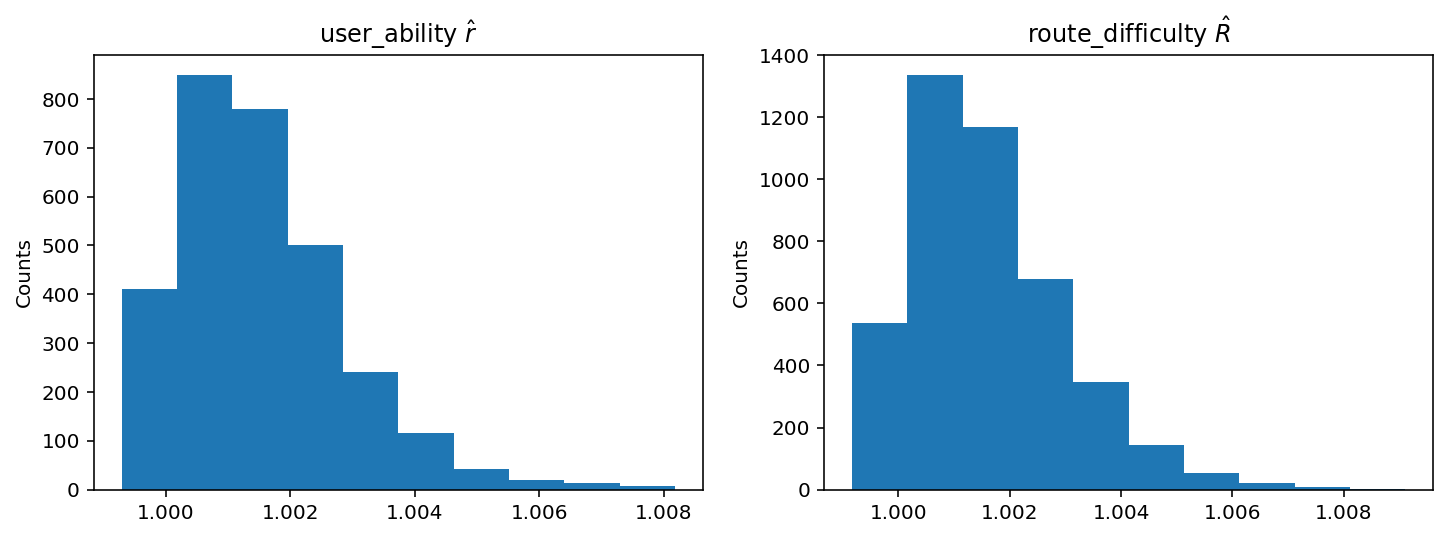

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs = axs.flatten()
axs[0].hist(model_summary["user_ability"].sel(metric="r_hat").values)
axs[0].set_title("user_ability $\hat{r}$")
axs[0].set_ylabel("Counts")
axs[1].hist(model_summary["route_difficulty"].sel(metric="r_hat").values)
axs[1].set_title("route_difficulty $\hat{R}$")
axs[1].set_ylabel("Counts")
None

## Viz

Now that we can feel somewhat comfortable that we've fitted a halfway-decent model, let's see what pops out. To start, we can make density plots of the posteriors for all routes, grouped by the route difficulty. We'll do this in the style of a [joyplot](https://en.wikipedia.org/wiki/Unknown_Pleasures) below for Rope and Bouldering routes separately. As we would hope to see, the posterior difficulties are larger for routes with higher ratings.

In [24]:
def joyplot(df: pd.DataFrame, routes: pd.DataFrame, rating_col: str, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 15))

    if rating_col == "route_rating":
        climb_type = 0
    elif rating_col == "bouldering_grade":
        climb_type = 1
    else:
        raise ValueError(f"Invalid rating_col={rating_col!r}")

    difficulties = df[rating_col].cat.remove_unused_categories().values.categories
    color_map = plt.cm.viridis(np.linspace(0, 1, len(difficulties)))
    ax.set_prop_cycle(cycler.cycler("color", color_map))
    total_offset = 0
    delta = 0.2
    num_points = 100
    points = np.linspace(-7, 7, num_points)
    xmax = 0.0
    zorder = len(difficulties)
    for difficulty, color in zip(difficulties, color_map):
        these_routes = df.loc[
            (df["climb_type"] == climb_type) & (df[rating_col] == difficulty),
            "route_idx",
        ].unique()

        if len(these_routes) > 0:
            these_difficulties = route_difficulties.loc[these_routes].values.ravel()
            kernel = gaussian_kde(these_difficulties)
            density = kernel(points)
            ax.plot(
                points,
                density + total_offset,
                color="k",
                linewidth=1,
                label=difficulty,
                zorder=zorder,
            )
            ax.fill_between(
                points,
                total_offset,
                density + total_offset,
                color=color,
                zorder=zorder,
                alpha=0.5,
            )
            x, y = (points[-1], (density + total_offset)[-1])
            ax.annotate(difficulty, xy=(x, y), xytext=(1.02 * x, y), color="k")
            total_offset += delta
            zorder -= 1
    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] * 1.05, xlim[1] * 1.05)
    ax.set_xlabel("Route Difficulty", fontsize=18)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_yticks([])
    ax.set_yticks([], minor=True)
    return ax

In [25]:
route_difficulties = (
    idata["posterior"]["route_difficulty"].to_dataframe().unstack(level=[0, 1])
)

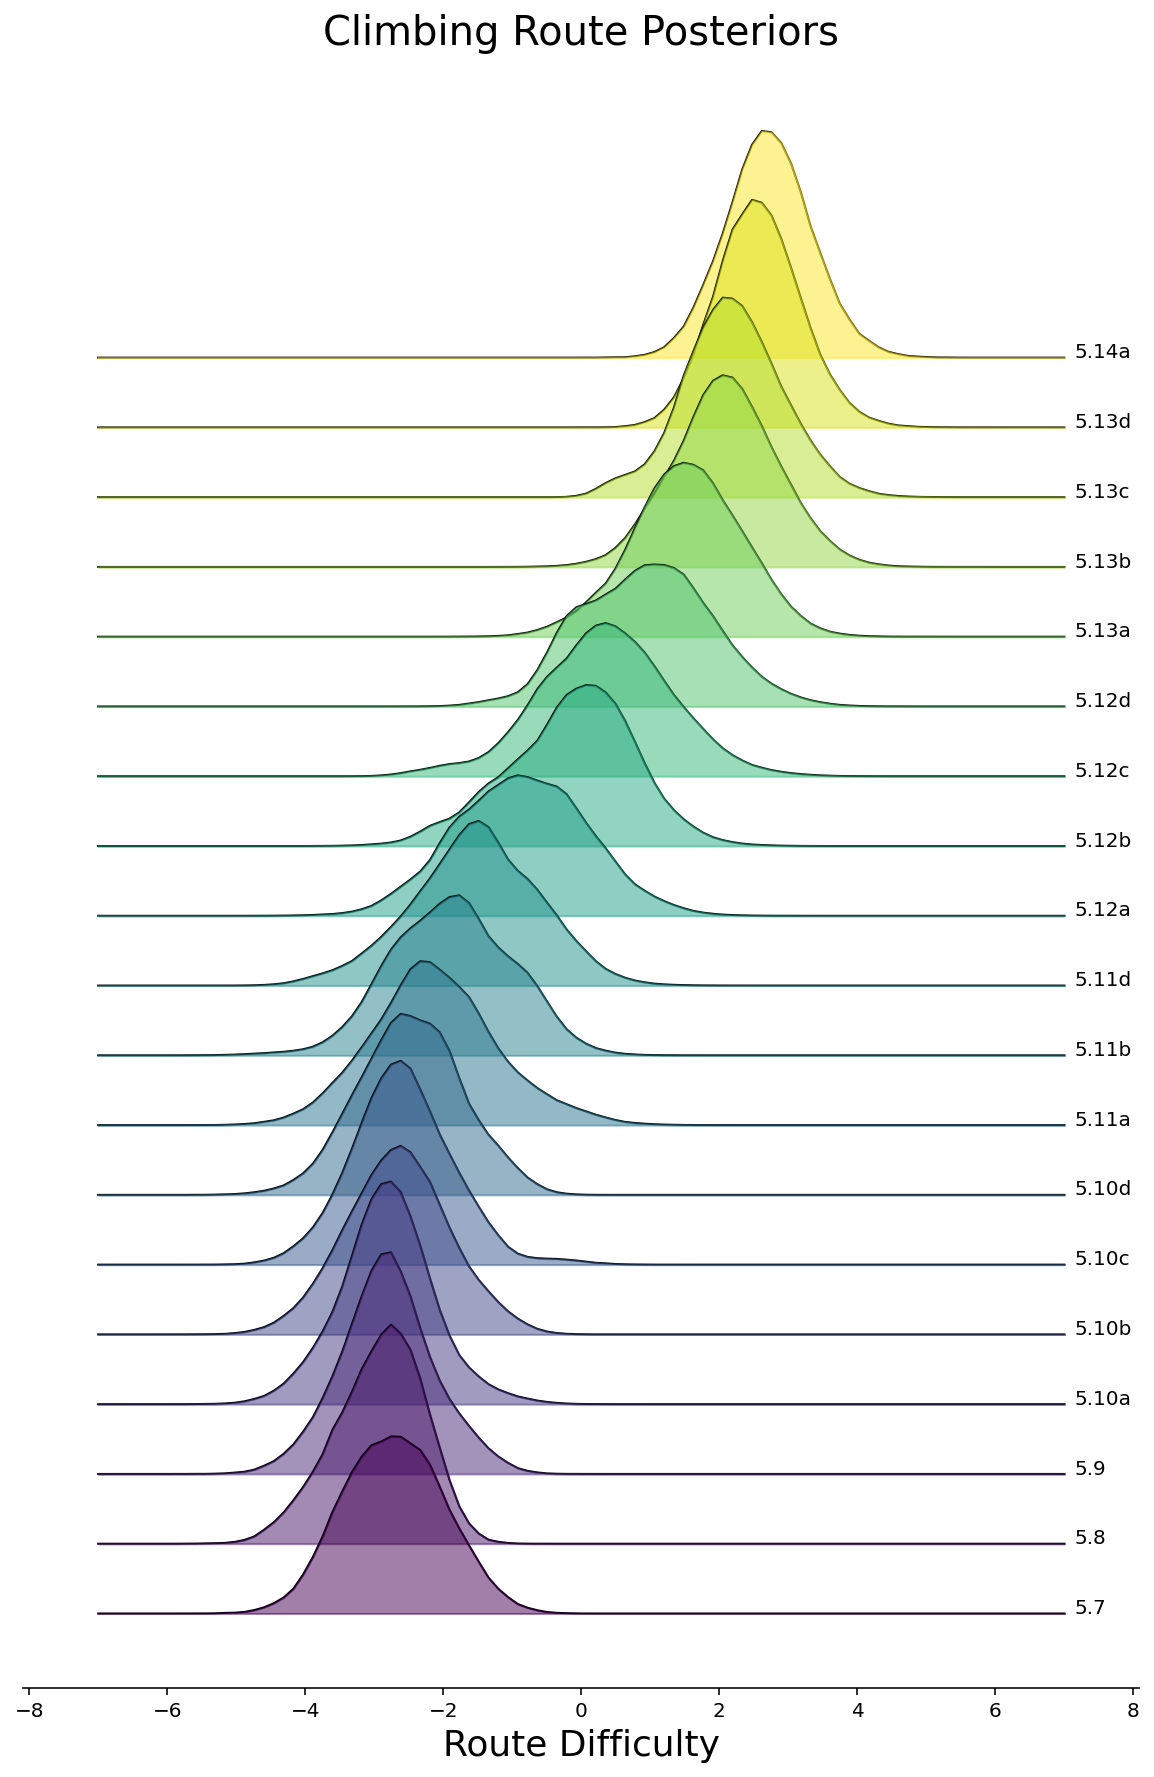

In [26]:
ax = joyplot(df, route_difficulties, "route_rating")
ax.set_title("Climbing Route Posteriors", fontsize=20)
None

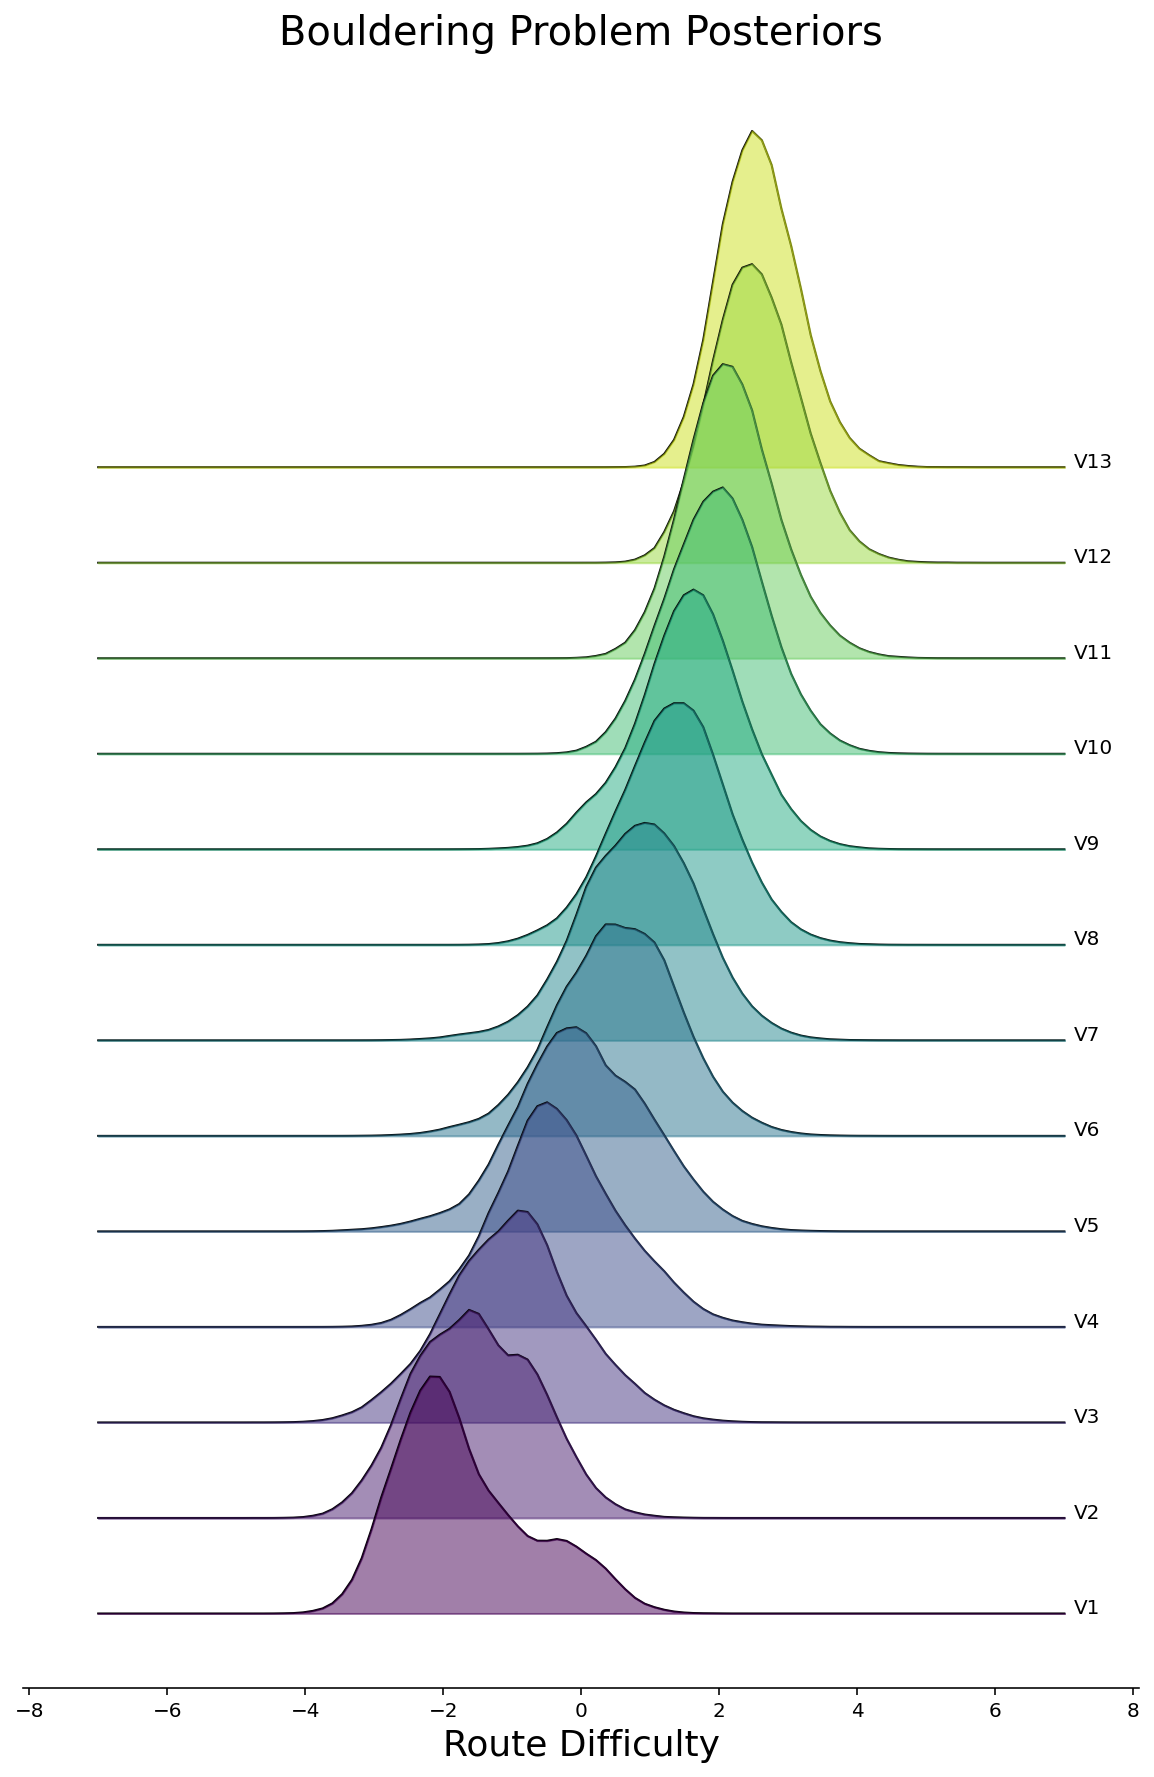

In [27]:
ax = joyplot(df, route_difficulties, "bouldering_grade")
ax.set_title("Bouldering Problem Posteriors", fontsize=20)
None

We can discard the full posterior and just look at the mean difficulties for each route. We will scatter plot these below, again grouped by rating. Hovering over each point shows the name of the climb.

In [28]:
def get_route_difficulties(
    df: pd.DataFrame, climb_type: str, model_summary
) -> pd.DataFrame:
    climb_type_map = {"rope": 0, "boulder": 1}
    if climb_type not in climb_type_map:
        raise ValueError(f"climb_type must be one of {list(climb_type.keys())!r}")

    climb_type_ascents = df[df["climb_type"] == climb_type_map[climb_type]]
    routes = climb_type_ascents[
        [
            "route_id",
            "route_idx",
            "crag",
            "route_name",
            "route_rating",
            "bouldering_grade",
        ]
    ].drop_duplicates()

    # Merge difficulties
    # This dataframe is indexed by the route_idx
    route_difficulties = model_summary["route_difficulty"].to_dataframe().loc["mean"]

    routes = pd.merge(routes, route_difficulties, left_on="route_idx", right_index=True)
    return routes

In [29]:
def make_stripplot(routes: pd.DataFrame, rating_col: str, title: str):
    rating_order = (
        routes[rating_col]
        .cat.remove_unused_categories()
        .values.categories.tolist()[::-1]
    )

    stripplot = (
        alt.Chart(routes, width=500, height=40, title=title)
        .mark_circle(size=50)
        .encode(
            y=alt.Y(
                "jitter:Q",
                title=None,
                axis=alt.Axis(values=[0], ticks=True, grid=False, labels=False),
                scale=alt.Scale(),
            ),
            x=alt.X("route_difficulty:Q", title="Route Difficulty"),
            color=alt.Color(
                f"{rating_col}:N",
                legend=None,
                scale=alt.Scale(scheme="viridis"),
                sort=rating_order,
            ),
            row=alt.Row(
                f"{rating_col}:N",
                title="Rating",
                header=alt.Header(
                    labelAngle=0,
                    titleOrient="left",
                    labelOrient="left",
                    labelAlign="left",
                    labelPadding=3,
                ),
                sort=rating_order,
            ),
            tooltip=["crag", "route_name"],
        )
        .transform_calculate(
            # Generate Gaussian jitter with a Box-Muller transform
            jitter="sqrt(-2*log(random()))*cos(2*PI*random())"
        )
        .configure_facet(spacing=0)
        .configure_view(stroke=None)
    )

    return stripplot

In [30]:
rope_routes = get_route_difficulties(df, "rope", model_summary)
make_stripplot(rope_routes, "route_rating", "Climbing Route Difficulties")

alt.Chart(...)

In [31]:
boulder_routes = get_route_difficulties(df, "boulder", model_summary)
make_stripplot(boulder_routes, "bouldering_grade", "Bouldering Problem Difficulties")

alt.Chart(...)

In lieu of actually climbing the routes, we can lookup reviews for routes that have anomalously low or high difficulty for their rating. Student Loan at [Rumney](https://www.mountainproject.com/area/105867829/rumney) appears to be the hardest 5.11a climb. Looking the route up on [Mountain Project](https://www.mountainproject.com/route/105962327/student-loan), we can see that they rate it 5.11b, and the description says:

>I've heard this route called 5.11a, but I think its crux is harder, so I called it 5.11b....

Seems like our model was right to rate this a very hard 5.11a!

On the other hand, the easiest 5.11b is I Just Do Eyes at [Ten Sleep Canyon](https://www.mountainproject.com/area/105819641/ten-sleep-canyon), and there's no indication from the [reviews](https://www.mountainproject.com/route/105855562/i-just-do-eyes) on Mountain Project that this is a particularly easy route. It's almost like our model isn't perfect.

## Our Model is Wrong

In fact, as I mentioned at the top, our model is most definitely wrong. There are some obvious signs: there is heavy overlap between ratings. For example, there are some 5.11a climbs that have higher difficulties than some 5.12d climbs. I highly doubt that this is true, no matter how subjective the ratings are! 

So why is our model wrong? One glaring issue is that we assume `user_ability` is static whereas people typically get better at climbing over time. People also get worse. Remember that pandemic when gyms were closed? 

As mentioned before, the data also has issues. It'd be much better to fit an ordinal regression model (as is done in the Stitch Fix post) to predict something related to how many tries it took the user to climb the route (e.g. `1st try`, `2-10`, `11+`, `Never`).The dataset is likely biased, too. There is limited data for easier climbs, so the difficulties are likely not as well-calibrated. We are trusting that people report their climbs accurately.

Nevertheless, even though all of this was wrong, I had fun making these plots. If climbing gyms ever started to track this data, they could more objectively rate their routes. They could even solve the "cold start rating" problem by having a couple people climb the route and then automatically assign a rating. Until then, if you can't climb the route, then just tell yourself that it's [sandbagged](https://www.climbernews.com/what-is-a-sandbag-in-climbing/).